<a href="https://colab.research.google.com/github/naimQA/android/blob/master/kprotocole_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import files
uploaded = files.upload()

Saving marketing_campaign.csv to marketing_campaign (1).csv


In [9]:
import pandas as pd
df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [10]:
df = df.drop(columns=['ID','Z_CostContact','Z_Revenue'])


In [11]:
df['Marital_Status'] = df['Marital_Status'].replace({
    'Alone':'Single','Absurd':'Single','YOLO':'Single'
})

In [12]:
import datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)
ref_date = df['Dt_Customer'].max()
df['Age'] = ref_date.year - df['Year_Birth']
df = df.drop(columns=['Year_Birth','Dt_Customer'])

In [13]:
num_cols = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts',
            'MntSweetProducts','MntGoldProds','NumWebPurchases',
            'NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth',
            'Income','Age']
cat_cols = ['Education','Marital_Status']
num_df = df[num_cols].copy()
cat_df = df[cat_cols].copy()

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_df[num_cols] = scaler.fit_transform(num_df[num_cols])

In [26]:
# Concatenate the dataframes
num_df = num_df.fillna(num_df.mean())
data_for_clust_df = pd.concat([num_df, cat_df], axis=1)

# Get the column indices of the categorical columns from the DataFrame
cat_indices = [data_for_clust_df.columns.get_loc(col) for col in cat_cols]

# Convert the DataFrame to a NumPy array for clustering
data_for_clust = data_for_clust_df.to_numpy()

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd # Ensure pandas is imported if it wasn't in the notebook

wss = []
sil_scores = []

# Impute missing values in num_df with the mean of each column
# This addresses the ValueError caused by NaNs in the input data for KMeans
num_df = num_df.fillna(num_df.mean())

for k in range(2, 8):
    # Now num_df should not contain any NaNs, allowing KMeans to fit
    km = KMeans(n_clusters=k, random_state=42).fit(num_df)
    wss.append(km.inertia_)
    sil_scores.append(silhouette_score(num_df, km.labels_))

In [28]:
!pip install kmodes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
k = 3
kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42)
# data_for_clust now has imputed numerical columns, so fit_predict should work
clusters = kproto.fit_predict(data_for_clust, categorical=cat_indices)
df['Cluster'] = clusters

In [29]:
print(df.groupby('Cluster')[['MntWines','NumWebPurchases','Income','Age']].mean())


           MntWines  NumWebPurchases        Income        Age
Cluster                                                      
0        508.303987         6.490033  59927.498322  49.063123
1         47.666055         2.214679  35397.590529  43.019266
2        589.162409         5.162409  77237.412523  45.270073


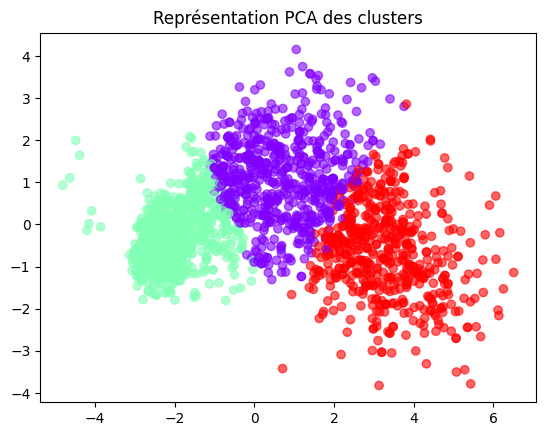

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
coords = pca.fit_transform(num_df)
plt.scatter(coords[:,0], coords[:,1], c=df['Cluster'], cmap='rainbow', alpha=0.6)
plt.title("Représentation PCA des clusters"); plt.show()